# Pocket Planet


#### Authors:
v1.0 (2020 Spring) Alexander Khazatsky, William Gan, Kannan Ramchandran


v2.0 (2023 Spring) Andy Dong

## Introduction

In this lab, we simulate the growth and evolution of vegetation in coastal areas and try to understand how biological evolution is affected by gene type, rate of mutation, land type, and other variants. To do so, we will set up a world and treat plants as particles. At each time step, these plants will reproduce and compete with each other for the limited space, in the process passing on the fitter genes.

Below is an example of such a simulation we will build.

<div>
  <table>
    <tr>
      <td>
        <img src="images/cover_photo.png" width="400"/>
      </td>
    </tr>
  </table>
</div>

In [1]:
from pocket_planet_utils import *

## Part 1: Generating the World

The first step to our simulation is to build the world. But how do we generate elevations and lanscapes that look realistic? A lot of research has been poured into this, and one method which has been successful is Perlin noise, which you can rea more about on [Wikipedia](https://en.wikipedia.org/wiki/Perlin_noise) and this [blog post](https://flafla2.github.io/2014/08/09/perlinnoise.html). It is used in both animated movies and Minecraft, and we will use it too in this lab. Below you will find perlin noise in 1, 2, and 3 dimensions.

<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_noise.png", width=875px>
      </td>
    </tr>
 </table>
</div>


We will design our world to be a 100 pixel by 100 pixel square with 7 terrains: ocean, shallows, sand, dirt, inland, mountain, and snow. Each terrain will corresponds to an elevation range, and so to generate our world, we just need to generate 2-dimensional perlin noise to use for our elevations. The following pictures show what the elevations and worlds should end up looking like.

<div>
  <table>
    <tr>
      <td>
        <img src="images/elevations.png">
      </td>
      <td>
        <img src="images/uninhabited.png">      
      </td>
    </tr>
  </table>
</div>

Now, to generate the functions of each frequency, we create a $(l+1) \times (l+1)$ array of unit gradient vectors (kind of like what is shown on the left), where $l$ is the maximum frequency (in the above picture, it is 128). Each square in this grid has 4 gradient vectors on the corner, as shown on the right.

<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_gradients.png">
      </td>
      <td>
        <img src="images/perlin_grad_4.png">
      </td>
    </tr>
 </table>
</div>

The cell below generates $n$-dimensional gradient vectors with unit length. Each gradient vector is computed by independently sampling from $\mathcal{N}(0, I_n)$ and then normalizing it to be unit length.

In [2]:
def generate_gradient(n):
    grad = np.random.normal(size=n)
    norm = np.linalg.norm(grad)
    gradient = grad / norm
    return gradient

The cell below, generates the array of gradients for the 2D case as a NumPy array with shape $(l+1, l+1, 2)$.

In [3]:
def generate_corner_gradients(l):
    corners = np.array([generate_gradient(2) for _ in range((l+1) * (l+1))])
    corners = corners.reshape(l+1, l+1, 2)
    return corners

Now comes the interpolation part. For a general point in $[0, l] \times [0, l]$, we find which square it lies by looking at the floor and ceiling of its x and y coordinates. Then, we compute the dot product of the gradient vector and "delta" vector for each of the 4 corners of the square it lies in. The "delta" vectors for a point in one of the $l \times l$ squares is shown below.

<div>
  <table>
    <tr>
      <td>
        <img src="images/perlin_dist_4.png">
      </td>
    </tr>
 </table>
</div>

In [4]:
def compute_dot_products(gradients, x, y):
    floor_x, floor_y = int(x), int(y)
    ceil_x, ceil_y = floor_x + 1, floor_y + 1
    corner_coords = np.array([[[floor_x, floor_y], [ceil_x, floor_y]],
                              [[floor_x, ceil_y], [ceil_x, ceil_y]]])
    corner_gradients = gradients[floor_y: ceil_y+1, floor_x: ceil_x+1]
    delta = np.array([x, y]) - corner_coords
    return np.sum(corner_gradients * delta, axis=2)

Now we want to interpolate a value at (x, y) given the values at the 4 corners. It turns out a nice function for doing this involves a degree-5 polynomial.

In [5]:
def smooth_interp(t, a, b):
    smooth_t = 6*t**5 - 15*t**4 + 10*t**3
    return (1 - smooth_t) * a + smooth_t * b

Bilinearly interpolate.

In [6]:
def interpolate(dots, x, y):
    dx = x - np.floor(x)
    dy = y - np.floor(y)
    interp1 = smooth_interp(dx, dots[0, 0], dots[0, 1])
    interp2 = smooth_interp(dx, dots[1, 0], dots[1, 1])
    interp = smooth_interp(dy, interp1, interp2)
    return interp

Now to put everything together, even though our array of gradients corresponds to a point in $[0, l] \times [0, l]$, each pixel in our 100 x 100 square world will just correspond to a point $[0, 1] \times [0, 1]$. However, we will still use the rest of the array as we will generate the higher frequency functions by mapping a point $x, y \in [0, 1] \times [0, 1]$ to $f \cdot x, f \cdot y \in [0, l] \times [0, l]$, where $f$ is the frequency.

In [7]:
def generate_world(size=100, l=4):
    grad = generate_corner_gradients(2 ** l + 1)
    units = np.linspace(0, 1, size)
    rescale_factor = (2 ** 0.5)
    grid = np.zeros((size, size))
    for i, x in enumerate(units):
        for j, y in enumerate(units):
            for log_f in range(l):
                f = 2 ** log_f
                amp = 1 / f
                new_x = x * f
                new_y = y * f
                dots = compute_dot_products(grad, new_x, new_y)
                val = interpolate(dots, new_x, new_y)
                rescaled_val = val * rescale_factor
                grid[j][i] += rescaled_val * amp
    grid /= 2 - 2 ** (1 - l)        
    return grid

You may have to run this cell and the cell below several times to get the world you want.

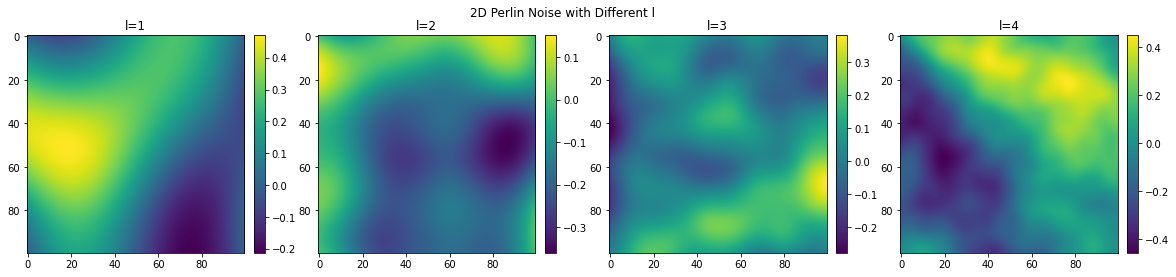

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
test_worlds = []
fig.suptitle('2D Perlin Noise with Different l')
for l in range(4):
    world = generate_world(l=l+1)
    test_worlds.append(world)
    ax[l].set_title(f'l={l+1}')
    im = ax[l].imshow(world)
    fig.colorbar(im, ax=ax[l], fraction=0.046, pad=0.04)

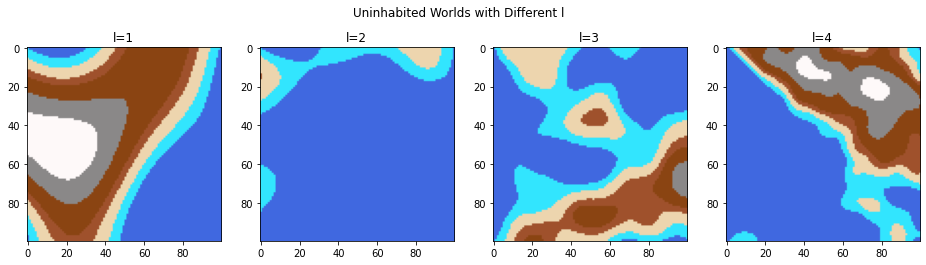

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Uninhabited Worlds with Different l')
for l in range(4):
    uninhabited_world = get_uninhabited_world(test_worlds[l])
    ax[l].set_title(f'l={l+1}')
    im = ax[l].imshow(uninhabited_world)

Use the knobs below to visualize worlds with defined height vectors for the enviorment types.

In [10]:
grid = generate_world()

@interact(ocean=h_o,shallows=h,beach=h,dirt=h,inland=h,mountain=h)
def toggle_ground_heights(ocean=0.01,
                          shallows=0.075,
                          beach=0.15,
                          dirt=0.2,
                          inland=0.3,
                          mountain=0.4,):
    heights = np.array([ocean, shallows, beach, dirt, inland, mountain, 1])
    visualize_height_values(heights, grid)

interactive(children=(FloatSlider(value=0.01, description='ocean', max=0.5, step=0.05), FloatSlider(value=0.07…

## Part 2: Bringing Particles to Life

Now that we have our terrain, we can set up our vegetation. The idea is our particles will be able to move around on our 100 x 100 grid, but first, we need to define the state of a particle. For simplicity, we assume the only kind of plant is trees. Each tree has DNA, which is a convex combination of 5 archetypes, each corresponding to an inhabitable land type in our world. (As a side note, a convex combination means a linear combination where the weights are non-negative and add up to 1. Also we consider ocean as not inhabitable for trees.) Here is the correspondence table of the land types and their ideal tree types. For example, a DNA of $[0.05, 0.05, 0.05, 0.8, 0.05]$ will be a tree well suited to live in the Inland environment.


<div>
  <table>
    <tr>
      <td>
        <img src="images/plant_land_table.png", width=400px>    
      </td>
    </tr>
  </table>
</div>

We will initialize a tree's DNA by sampling each element uniformly from $[0, 1]$ independently and normalizing this vector.

At each time step, a tree may have offpring (seeds) whose DNA will be slightly mutated. The mutation adds a small pertubation vector to the parent's DNA vector. The pertubation vector has each entry sampled uniformly from $[-\sigma, \sigma]$ for some small $\sigma$. Then, we clip each entry of the result to the range $[0, 1]$ and re-normalize.

You do not need to follow the steps above! You are free to design any initialization and mutation scheme that you want to experiment with, but make sure that at each time step, every tree's DNA vector is non-negative and sums to 1.

**Question 2a**. In the following cell, fill out the functions for generating the initial random DNA as well as generating offspring.

In [11]:
class Tree(AbstractTree):

    def initialize_random_dna(self):
        # START YOUR CODE HERE
        unnormalized_dna = np.random.random(5)
        dna = unnormalized_dna / np.sum(unnormalized_dna)
        # END YOUR CODE HERE
        self.dna = dna
    
    def generate_offspring(self, sigma):
        # START MAGNIFICENT CODE HERE
        mutation = np.random.uniform(-sigma, sigma, 5)
        unnormalized_dna = self.dna + mutation
        unnormalized_dna = unnormalized_dna.clip(0, 1)
        offspring_dna = unnormalized_dna / np.sum(unnormalized_dna)
        # END MAGNIFICENT CODE HERE
        return Tree(dna=offspring_dna)

Visualize DNA.

In [12]:
@interact(Shallow=r, Beach=r, Dirt=r, Inland=r, Mountains=r)
def f(Shallow, Beach, Dirt, Inland, Mountains):
    unnormalized_DNA = np.array([Shallow, Beach, Dirt, Inland, Mountains])
    DNA = unnormalized_DNA / np.sum(unnormalized_DNA)
    tree = Tree(DNA)
    visualize_dna(tree)

interactive(children=(FloatSlider(value=0.5, description='Shallow', max=1.0), FloatSlider(value=0.5, descripti…

Visualize mutations over multiple generations of a tree's DNA. Feel free to play with the variance and see how things change.

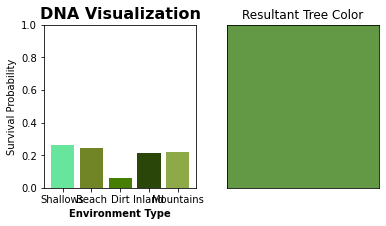

In [13]:
tree = Tree()
var = 0.01
for i in range(30):
    clear_output(wait=True)
    visualize_dna(tree)
    tree = tree.generate_offspring(var)

## Part 3: Defining The Mechanics

Now that we have our tree, we can define the mechanics that govern their survival and reproduction.

- Our world will initially be empty, but at each time step, a tree can magically appear in a square with probability `self.life_prob`, perhaps through an animal bringing over its seed. This is be implemented in `simulate_life_creation`.
- If tree is currently in a square, it survives each time step with some probability. This is implemented in `age_tree`.
- If it survives, it can then also generate a number of offspring. The number of offspring is sampled independently from a binomial distribution with $n=\text{self.max_seeds}$ and $p=\text{fitness}$. You can change this distribution to play with too! This is implemented in `generate_offspring`.
- Finally, if a bunch of trees are on the same square, they will compete for the square because resources are limited! Each tree $t$ on a square $s$ has an "energy" value that is equal to $\exp(\text{s.comp_constant} \cdot \text{t.fitness})$. Then, each tree on the square wins with probability proportional to its energy value. This is called the Boltzmann distribution and is implemented in `sample_boltzmann_distribution`.

**Question 3a**. Fill out the following class.

In [14]:
class Square(AbstractSquare):
    
    def simulate_life_creation(self):
        # Calls self.plant_seed(Tree()) with probability self.life_prob
        # START YOUR CODE HERE
        p = np.random.uniform() < self.life_prob
        if p:
            self.plant_seed(Tree())
        # END YOUR CODE HERE
                
            
    def age_tree(self):
        # Calls self.terminate_tree() with probability 1-survival_prob
        if not self.contains_tree():
            return
        survival_prob = self.tree.calc_fitness(self.env_type)
        
        # START YOUR CODE HERE
        p = np.random.uniform() > survival_prob
        if p:
            self.terminate_tree()
        # END YOUR CODE HERE
        

    def generate_offspring(self):
        # Returns a list of offspring as described above
        if not self.contains_tree():
            return []
        fitness = self.tree.calc_fitness(self.env_type)
        
        # START YOUR CODE HERE
        num_offspring = np.random.binomial(self.max_seeds, fitness)
        offspring = [self.tree.generate_offspring(self.mutation_var) for i in range(num_offspring)]
        # END YOUR CODE HERE
        
        return offspring
    
    
    def sample_boltzmann_distribution(self, fitness, return_dist=False):
        # START YOUR CODE HERE
        energy = np.exp(self.comp_constant * fitness)
        probabilities = energy / np.sum(energy)
        # END YOUR CODE HERE

        if return_dist:
            return probabilities
        winner_index = random.choices(np.arange(0, len(fitness)), probabilities)[0]
        return winner_index

**Question 3b**. Use the next cell to visualize evolution for a single square in our world.

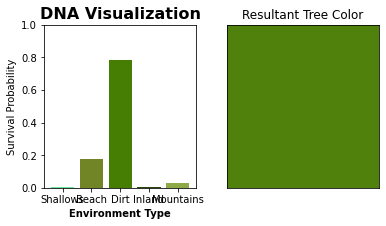

In [15]:
var = 0.03
comp_constant = 1000
    
square = create_secret_square(var, comp_constant, Square)

for i in range(50):
    plt.pause(0.1)
    clear_output(wait=True)
    psuedo_env_step(square, Tree)

Based on your investigations, answer the following questions:

1) What would you guess is the environment type of the square?

- Dirt

2) How does mutation variance affect the rate of convergence and the behavior once evolution has reached steady state?

- It makes the convergence progression more volitile when very high, and more slow and steady when low. 
- Once steady state is reached, a high mutation variance means that there will be more variation away from optimal fitness.

3) In a rapidly changing environment, would we want a high or low mutation rate? What about in a predictable environment?

- In a rapidly changing enviorment, we want a high mutation variance so we can keep up with changes. For a more predictable enviorment, we want a low mutation variance so we can converge steadily and stay there.

4) How does the competition constant affect rate of convergence and the behavior once evolution has reached steady state? 

- The rate of convergence towards optimal fitness increases as the competition constant increases, as the environment is more selective.
- When the constant is high, having better fitness increases in importance. This leads to low variation in the DNA distribution over time once it converges. Likewise, when the competition constant is low the variation of the DNA distribution is high because it is more likely that suboptimal trees will survive. 

## Q4 Bringing It All Together

You're almost done! All that is left is to make our particles be able to move across squares.

- In `simulate_movement`, we want to be able to move a particle from position $i, j$.  To do this, we'll sample new_coord from $Normal([i,j], var)$, then clip to [min_val, max_val], and finally round to the nearest integer.
- In `spread_seeds`, we'll get new positions for a seeds at $i, j$ by setting the variance for `simulate_movement`. If a square is an ocean, set variance to be self.waves_var. Otherwise, set it to be self.wind_var.

In [16]:
class World(AbstractWorld):
    def simulate_movement(self, i, j, var):
        coord = np.array([i, j])
        min_val, max_val = 0, self.dim - 1
        
        # START YOUR CODE HERE
        unclipped_coord = np.random.normal(coord, var**0.5)
        new_coord = np.clip(unclipped_coord, a_min=min_val,a_max=max_val)
        new_coord = np.round_(new_coord).astype('int64')
        # END YOUR CODE HERE
        # Note: make sure the elements of new_coord are integers
        
        return new_coord[0], new_coord[1]
    
    def spread_seeds(self, i, j):
        square = self.world[i][j]
        trees = square.get_seeds()
        
        if square.is_ocean():
            var = self.waves_var
        else:
            var = self.wind_var
            
        for tree in trees:
            x, y = self.simulate_movement(i, j, var)
            self.world[x][y].plant_seed(tree)

## Congratulations!

You're free! We hope you've enjoyed this evolutionary journey. We highly recommend tinkering with the hyperparameters. After putting in all this work, you might as well get some fun out of it. If you find any cool properties, feel free to write about it below!

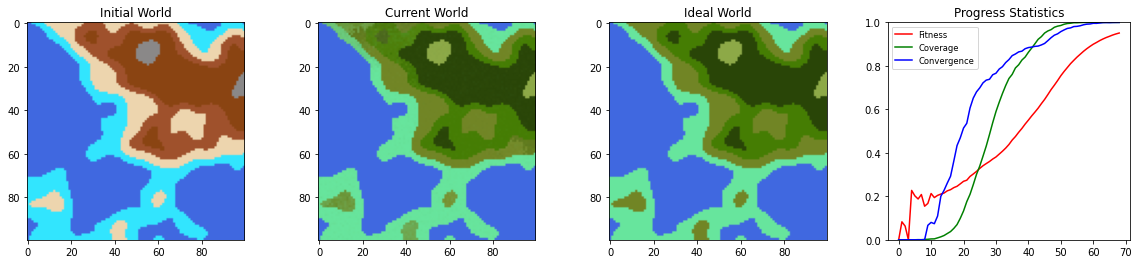

In [17]:
world = World(generate_world,
              Square,
              dim=100,
              mutation_var=0.03,
              comp_constant=100,
              wind_var=2,
              waves_var=5)

for i in range(70):
    world.env_step()

**Question 4a**. When life initially starts to spread accross the map, the fitness curve is extremely volatile, but eventually it smooths out. Why is this?

Once life first begins, it quickly starts to adapt to its current enviorment. However, the offspring spreads to different enviorment types which it is not fit for. Although these seeds are not well suited for these new enviorments, they grow due to the lack of competition. Once plant populations have grown thoughout the map, there is sufficient competiton for the law of large numbers to force steady fitness progression.

**Question 4b**. You might notice that the Coverage progression curve tends to match a sigmoid curve. Give a conjecture as to why this might be.

The rate of change of coverage depends heavily on two factors: the current coverage, and the amount of space remaining to cover. When starting out, the rate of change is limited by the former, which is growing, so it tends to grow exponentially. Once most of the map is covered, rate of change is limited by the latter, which is shrinking, so it behaves like exponential decay (but to 1 instead of 0).

## References

1. https://en.wikipedia.org/wiki/Perlin_noise
1. https://flafla2.github.io/2014/08/09/perlinnoise.html
1. https://gamedev.stackexchange.com/questions/23625/how-do-you-generate-tileable-perlin-noise